# Customer Segmentation


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [160]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [4]:
!unzip data.csv.zip

Archive:  data.csv.zip
replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Introduction

We will be analyzing and modeling customer purchase behavior using unsupervised learning technique of K-means Clustering to segment customers into groups based on their spending habits from an online retail store.

The dataset consists of transactional data from a UK-based retailer, including 540,000 samples from 2,400 customers. The dataset contains features such as stock code, product description, quantity, invoice date, unit price, customer ID, and additional invoice details. Our objective is to identify patterns in purchasing behavior and group customers accordingly.

The features are the following:

- Invoice number: Invoice Number

- stockcode: Unique code for each distinct product

- customer IDs: Unique ID for each cusomter

- description: Description of individual item

- quantity: Number of items bought

- UnitPrice: Price of individual unit

- InvoiceDate: Date of purchase

In [75]:
data = pd.read_csv("data.csv", encoding='ISO-8859-1')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
data.nunique()

,0
InvoiceNo,25900
StockCode,4070
Description,4223
Quantity,722
InvoiceDate,23260
UnitPrice,1630
CustomerID,4372
Country,38


### Exploratory Data Analysis


To effectively segment customers based on their spending behavior, we need to create a dataset with key features such as total amount spent, purchase frequency, and recency of their last transaction. Before aggregating the data into these features, we will first visualize and clean the dataset to ensure accuracy and remove any inconsistencies.

From the boxplots of Quantity and Price below, we observe that the majority of product prices are under $90,000. Additionally, there are some negative values for both unit price and quantity, which are likely erroneous. Therefore, we will filter out these rows to ensure data quality by removing the negative values.

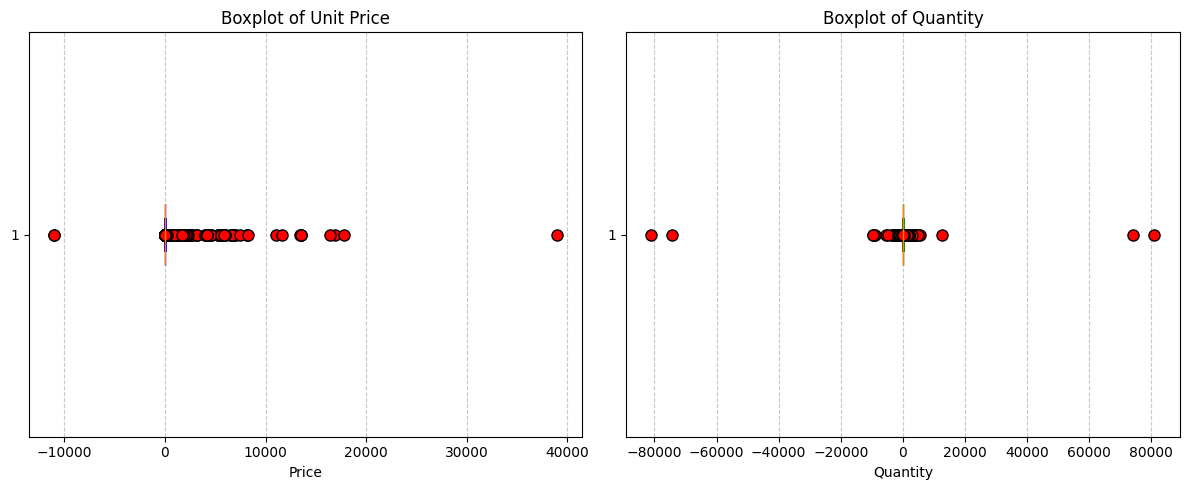

In [47]:
import matplotlib.pyplot as plt

# Create a figure with subplots (1 row and 2 columns)
plt.figure(figsize=(12, 5))

# Boxplot for UnitPrice
plt.subplot(1, 2, 1)  # First subplot (left)
plt.boxplot(data['UnitPrice'], vert=False, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            whiskerprops=dict(color='blue', linewidth=1.5),
            capprops=dict(color='blue', linewidth=2),
            flierprops=dict(marker='o', markerfacecolor='red', markersize=8, linestyle='none'))
plt.title('Boxplot of Unit Price', fontsize=12)
plt.xlabel('Price', fontsize=10)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Boxplot for Quantity
plt.subplot(1, 2, 2)  # Second subplot (right)
plt.boxplot(data['Quantity'], vert=False, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='green'),
            whiskerprops=dict(color='green', linewidth=1.5),
            capprops=dict(color='green', linewidth=2),
            flierprops=dict(marker='o', markerfacecolor='red', markersize=8, linestyle='none'))
plt.title('Boxplot of Quantity', fontsize=12)
plt.xlabel('Quantity', fontsize=10)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [76]:
data = data.drop(data[data["UnitPrice"] < 0 ].index)
data = data.drop(data[data["Quantity"] < 0 ].index)
data["Total"] = data["UnitPrice"]*data["Quantity"]

The table below displays the top 10 most popular products by quantity, which is also visualized in the bar graph. Upon reviewing the data, we observe that there are several '?' and 'NaN' values in the product names. To enhance the accuracy of our analysis and better segment the products, we will filter out these incomplete or missing entries.

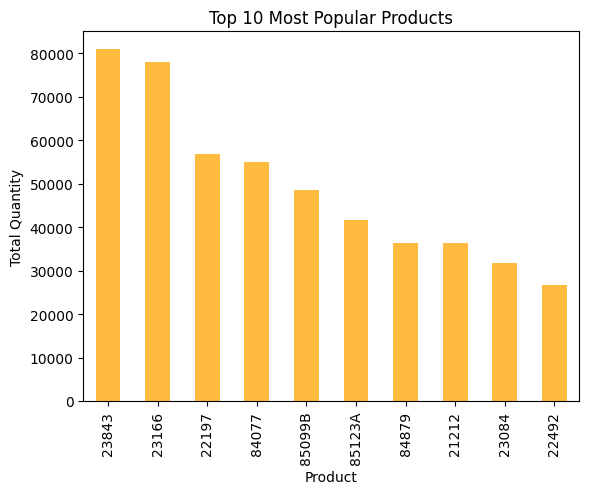

In [53]:
top_products = data.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='bar', alpha=0.75, color='orange')
plt.title('Top 10 Most Popular Products')
plt.xlabel('Product')
plt.ylabel('Total Quantity')
plt.show()

In [55]:
top_products = data.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products_with_names = top_products.reset_index().merge(data[['StockCode', 'Description']].drop_duplicates(),
                                                          on='StockCode',
                                                          how='inner')

# Display the result
print(top_products_with_names)

   StockCode  Quantity                          Description
0      23843     80995          PAPER CRAFT , LITTLE BIRDIE
1      23166     78033       MEDIUM CERAMIC TOP STORAGE JAR
2      22197     56921                 SMALL POPCORN HOLDER
3      22197     56921                       POPCORN HOLDER
4      84077     55047    WORLD WAR 2 GLIDERS ASSTD DESIGNS
5     85099B     48478              JUMBO BAG RED RETROSPOT
6     85123A     41664   WHITE HANGING HEART T-LIGHT HOLDER
7     85123A     41664                                    ?
8     85123A     41664   CREAM HANGING HEART T-LIGHT HOLDER
9      84879     36461        ASSORTED COLOUR BIRD ORNAMENT
10     21212     36419      PACK OF 72 RETROSPOT CAKE CASES
11     23084     31722                   RABBIT NIGHT LIGHT
12     23084     31722                                  NaN
13     23084     31722  allocate stock for dotcom orders ta
14     23084     31722  add stock to allocate online orders
15     23084     31722             for o

In [77]:
data = data[~data['Description'].isin([None, 'NaN', '?'])]
data = data.dropna(subset=['Description'])

In [78]:
data = data.dropna(subset=['CustomerID'])

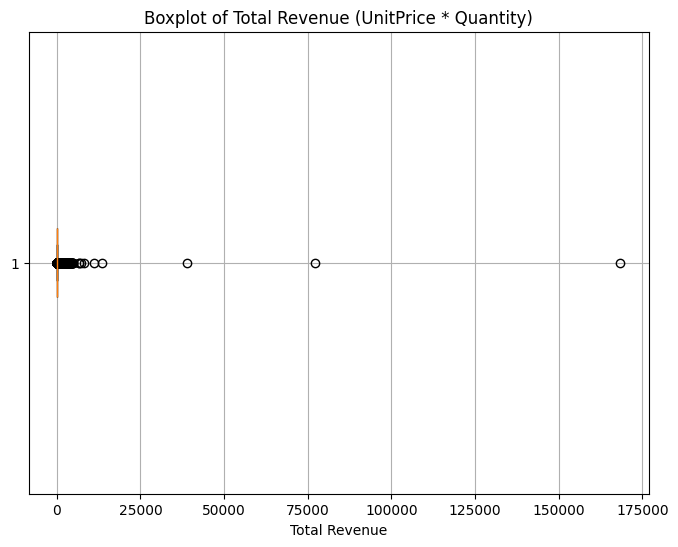

In [65]:
plt.figure(figsize=(8, 6))
plt.boxplot(data['Total'], vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))
plt.title('Boxplot of Total Revenue (UnitPrice * Quantity)')
plt.xlabel('Total Revenue')
plt.grid(True)
plt.show()

Now that we have removed invalid values, we can also remove extreme outliers as they will not improve our k-means clustering model performance. Outliers can also create skewed clusters which may not give us the most accurate groupings.

In [66]:
lower = data['Total'].quantile(0.05)
upper = data['Total'].quantile(0.95)

data = data.drop(data[data["Total"] > upper ].index)
data = data.drop(data[data["Total"] < lower ].index)

In [80]:
data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Total'],
      dtype='object')

Now that we have cleaned our data, we can aggregate each customer by total amount spent, purchase frequency, and how recent they made a purchase to create our dataset for model training.

In [ ]:
# Quantity bought by each customer
total_quantity_per_customer = data.groupby('CustomerID')['Quantity'].sum()

# # of Transactions
num_transactions_per_customer = data.groupby('CustomerID')['InvoiceNo'].nunique()

# Recency: How recent a customer made a purchase
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
recency_per_customer = data.groupby('CustomerID')['InvoiceDate'].max()
recency_per_customer = (data['InvoiceDate'].max() - recency_per_customer).dt.days

# Prepare the customer data for clustering
customer_features = pd.DataFrame({
    'TotalSpent': data.groupby('CustomerID')['Total'].sum(),
    'Frequency': num_transactions_per_customer,
    'Recency': recency_per_customer
}).reset_index()

## Unsupervised Learning Model

We will segment our customers using K-Means clustering on our newly aggregated dataset. First, we will scale the data to ensure consistency across features. Then, we will determine the optimal number of clusters using the elbow method. Once we have our initial clusters, we will further refine and analyze them in the 'Analysis' section to ensure meaningful and accurate segmentation.

Since the features have different value ranges, we will use StandardScaler() to standardize them. This will transforms the features so that they have a mean of 0 and a standard deviation of 1. This will result in a scale of 0-1. Standardization will helps improve the performance and stability of K-Means clustering, which is sensitive to varying feature magnitudes.

In [260]:
scaler = StandardScaler()
customer_features_scaled = scaler.fit_transform(customer_features[['TotalSpent', 'Frequency', 'Recency']])


Based on the graph using elbow method below, the optimal number of clusters should be 5.

<Axes: title={'center': 'The Elbow Method'}, xlabel='k', ylabel='SSE'>

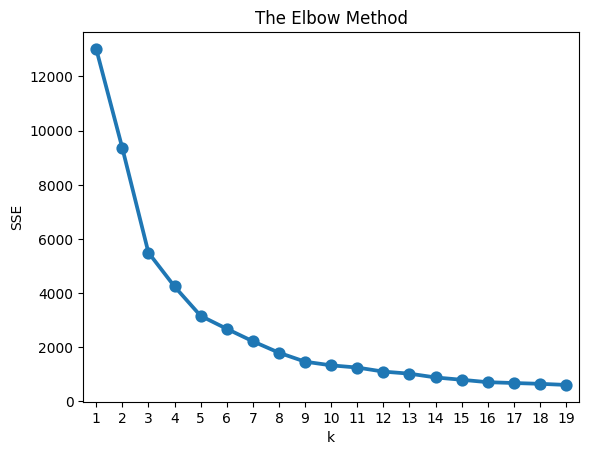

In [263]:
sse = {}
for k in range(1,20):
    kmeans = KMeans(n_clusters=k, random_state=30)
    kmeans.fit(customer_features_scaled)
    sse[k] = kmeans.inertia_

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y = list(sse.values()))

In [264]:
kmeans = KMeans(n_clusters=5, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(customer_features_scaled)

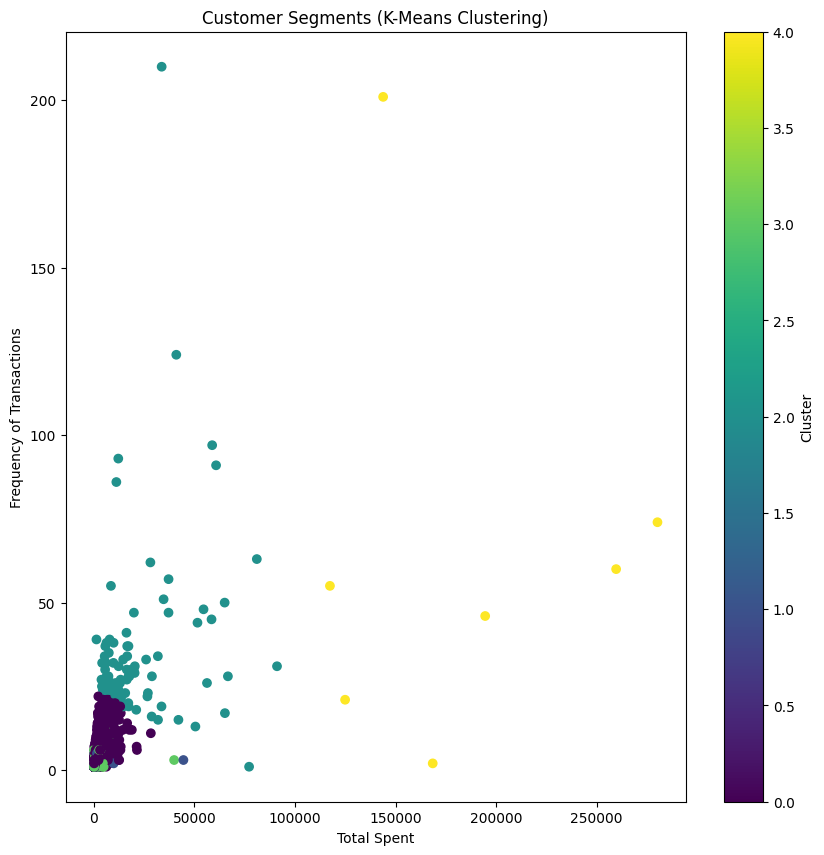

In [265]:
plt.figure(figsize=(10, 10))
plt.scatter(customer_features['TotalSpent'], customer_features['Frequency'], c=customer_features['Cluster'])
plt.xlabel('Total Spent')
plt.ylabel('Frequency of Transactions')
plt.title('Customer Segments (K-Means Clustering)')
plt.colorbar(label='Cluster')
plt.show()

## Analysis

Next, we will evaluate our model by analyzing the quality of the clusters. We will visualize the cluster characteristics to better understand customer purchase behavior and assess the model's performance using the silhouette score.

We got a silhouette score of 0.43 which is not the best and our clustering still needs some improvements. The cluster comparison graph also does not scale well enough for features such as TotalSpent and Frequency so we can try a different scaling method to begin with. Furthermore, the clusters are also overlapping which does not give us reliable information to segment the customers.

In [273]:
sil_score = silhouette_score(customer_features_scaled, customer_features['Cluster'])
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.436332769590958


In [ ]:
cluster_description = customer_features.groupby('Cluster')[['TotalSpent', 'Frequency', 'Recency']].mean()


In [271]:
df = pd.DataFrame(cluster_description)

# Scale data using Min-Max scaling
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)


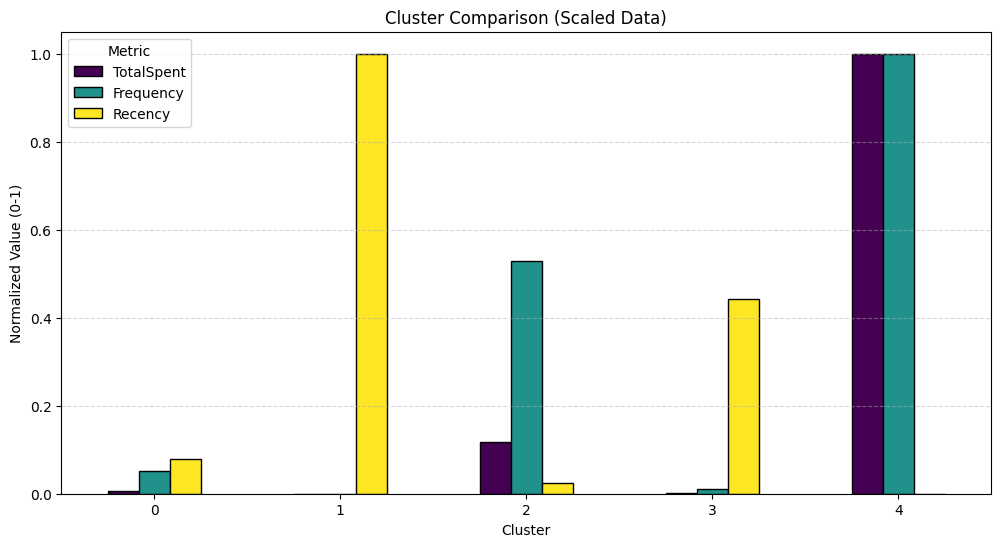

In [272]:
# Bar Chart for Scaled Data
df_scaled.plot(kind='bar', figsize=(12, 6), colormap='viridis', edgecolor='black')

plt.title("Cluster Comparison (Scaled Data)")
plt.xlabel("Cluster")
plt.ylabel("Normalized Value (0-1)")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


Instead of standardizing our features, we will use RobustScaler() instead to scale the data. RobustScaler is best for data with outliers and it uses median and interquartile range instead of mean and standard deviation. This will also reduce the impact of extreme values.

In [337]:
scaler = RobustScaler()
customer_features_scaled = scaler.fit_transform(customer_features[['TotalSpent', 'Frequency', 'Recency']])

kmeans = KMeans(n_clusters=5)
customer_features['Cluster'] = kmeans.fit_predict(customer_features_scaled)

In [338]:
sil_score = silhouette_score(customer_features_scaled, customer_features['Cluster'])
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.7298676945789602


In [341]:
kmeans = KMeans(n_clusters=5, n_init=50, max_iter = 700)

In [342]:
customer_features['Cluster'] = kmeans.fit_predict(customer_features_scaled)
sil_score = silhouette_score(customer_features_scaled, customer_features['Cluster'])
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.7325912603268835


## Results

By tuning our K-mean Clustering model and reprocessing the data, we managed to significantly improve our silhouette score to 0.73 from 0.43. This indicates well-defined, high-quality clusters, allowing for more accurate insights into customer purchasing behavior.

Clustering Method, Scaler, n_clusters, n_init, max_iter, silhouette score
K-means, StandardScaler, 5, 20, 300, 0.43
K-means, RobustScaler, 5, 20, 300, 0.72
K-means, RobustScaler, 5, 50, 700, 0.73


\begin{array}{|c|c|c|c|c|c|}
\hline
\textbf{Clustering Method} & \textbf{Scaler} & \textbf{n_clusters} & \textbf{n_init} & \textbf{max_iter} & \textbf{Silhouette Score} \\
\hline
\text{K-means} & \text{StandardScaler} & 6 & 20 & 300 & 0.37 \\
\hline
\text{K-means} & \text{StandardScaler} & 5 & 20 & 300 & 0.43 \\
\hline
\text{K-means} & \text{RobustScaler} & 5 & 20 & 300 & 0.72 \\
\hline
\text{K-means} & \text{RobustScaler} & 5 & 50 & 700 & 0.73 \\
\hline
\end{array}


Firstly, we applied a RobustScaler as it is best for data with outliers. Then, we set n_init to 50 which chooses 50 random initial points for clusters until the model finds an optimal centroid and help improve the clustering quality. Finally we increased maximum iterations to 700.



In [ ]:
cluster_description = customer_features.groupby('Cluster')[['TotalSpent', 'Frequency', 'Recency']].mean()

In the Cluster Comparison graph below, we can observe that the metrics for the clusters have scaled better for us to determine the different customer segments more accurately and they give us better insight into the customer base.

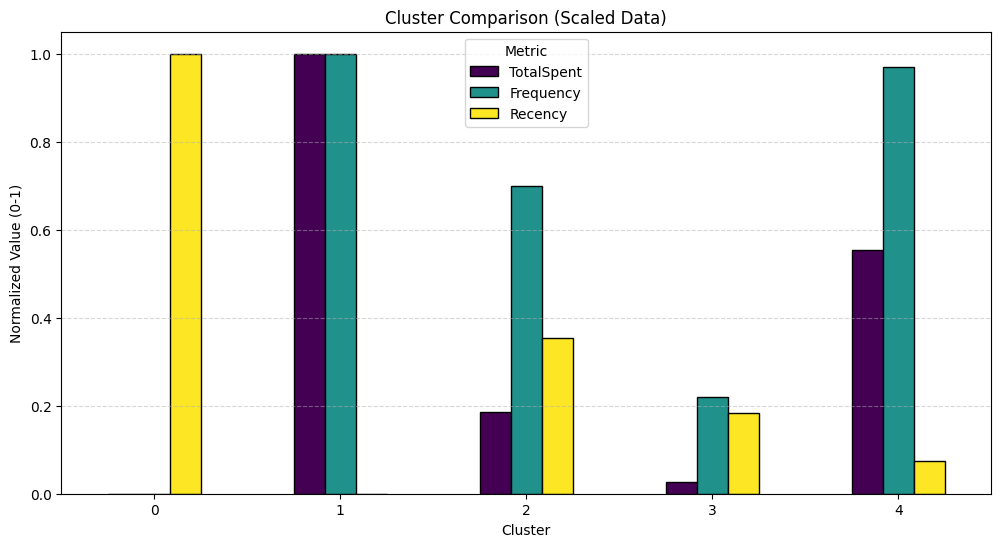

In [346]:
df = pd.DataFrame(cluster_description)

# Scale data using Min-Max scaling
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Bar Chart for Scaled Data
df_scaled.plot(kind='bar', figsize=(12, 6), colormap='viridis', edgecolor='black')

plt.title("Cluster Comparison (Scaled Data)")
plt.xlabel("Cluster")
plt.ylabel("Normalized Value (0-1)")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In the graph below, we can see that our clusters do not overlap with other clusters as much anymore. Thus, it further illustrates the quality of our clusters.

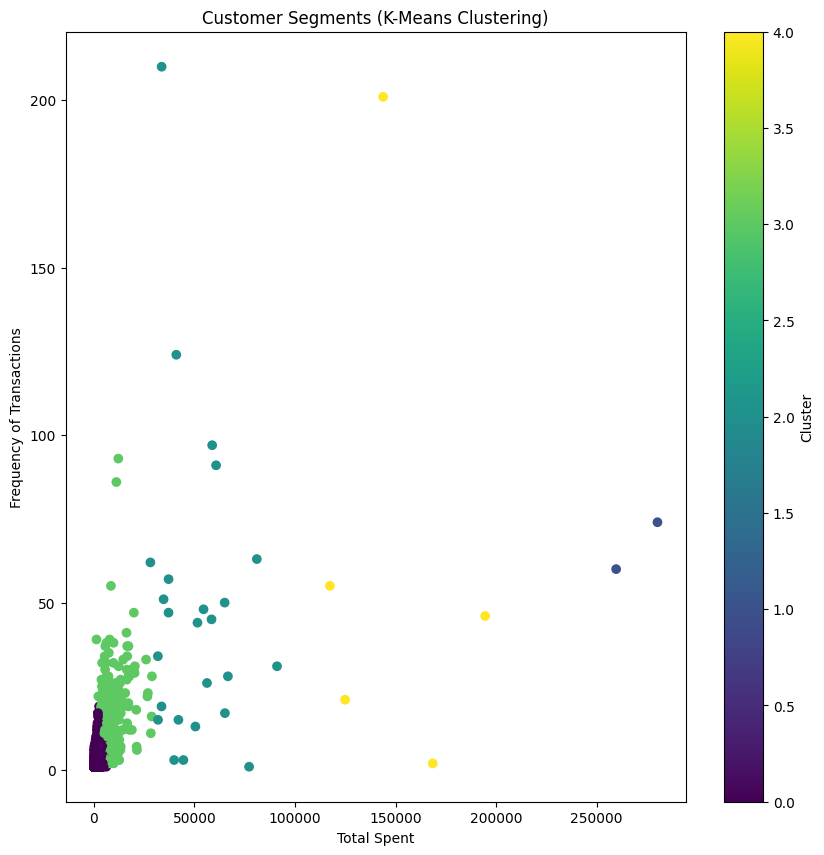

In [347]:
plt.figure(figsize=(10, 10))
plt.scatter(customer_features['TotalSpent'], customer_features['Frequency'], c=customer_features['Cluster'])
plt.xlabel('Total Spent')
plt.ylabel('Frequency of Transactions')
plt.title('Customer Segments (K-Means Clustering)')
plt.colorbar(label='Cluster')
plt.show()

## Conclusion

As a result of our clustering and analysis, I am able to cluster the customers in the following 5 groups:
1. Cluster 0: Very low amount spent, very low purchase frequency, no recent purchases
2. Cluster 1: High amount spent, high purchase frequency, recent purchases
3. Cluster 2: Low amount spent, moderate purchase frequency, moderate recent purchases
4. Cluster 3: Low amount spent, low purchase frequency, no recent purchases
5. Cluster 4: Very high amount spent, very high purchase frequency, very recent purchases

Next time, I would experiment with the full dataset without removing extreme outliers. Since we ended up using RobustScaler, which is designed to handle outliers effectively, keeping them would have provided more data for training and potentially improved accuracy and cluster quality. Furthermore, I would explore Hierarchical Clustering to compare performance and accuracy with K-Means. That said, the silhouette score of 0.73 is still strong and provides valuable insights into customer segmentation.

## References

- University of California, Irvine. Online Retail Data Set. UCI Machine Learning Repository, 2011, https://archive.ics.uci.edu/dataset/352/online+retail

- Prashant111. K-Means Clustering with Python. Kaggle, https://www.kaggle.com/code/prashant111/k-means-clustering-with-python. Accessed 2025.